<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/K%E8%BF%91%E5%82%8D%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# k近傍法 (kNN) による異常検知（初心者向け・1セル版）
# 手順:
# 1) 2次元の正規分布（相関あり）から学習用の「正常」データを作成
# 2) テスト用に「正常＋異常」を混ぜたデータを作成
# 3) 学習データの平均・標準偏差で Z 標準化（スケール合わせ）
# 4) 学習・テストそれぞれの「k近傍距離の平均」をスコアとする
# 5) 学習スコアの上位 α 分位点をしきい値にして、テストスコアが超えたら異常
# 6) 可視化（元空間の散布図＋しきい値等高線、スコアのヒストグラム）

import numpy as np
import matplotlib.pyplot as plt

In [10]:

np.random.seed(0)


In [11]:
# ===== 1) 学習データ（正常）と 2) テストデータ（正常＋異常） =====
k = 10            # 近傍数（5〜20で試すとよい）
alpha = 0.99      # 学習スコアの上位 α 分位点をしきい値に
n_train = 400
n_test_norm = 200
n_test_out = 20

mu = np.array([0.0, 0.0])
Sigma = np.array([[3.0, 2.0],
                  [2.0, 5.0]])   # 非直交（相関あり）

train = np.random.multivariate_normal(mu, Sigma, size=n_train)      # 学習：正常のみ
test_norm = np.random.multivariate_normal(mu, Sigma, size=n_test_norm)  # テスト：正常

# 異常は平均を大きくずらす（分かりやすくするため）
mu_out = np.array([6.0, -6.0])
Sigma_out = np.array([[1.0, 0.2],
                      [0.2, 1.0]])
test_out = np.random.multivariate_normal(mu_out, Sigma_out, size=n_test_out)

test = np.vstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int), np.ones(len(test_out), dtype=int)])  # 0=正常,1=異常(真)

In [12]:
# ===== 3) 学習データで Z 標準化 =====
mu_hat = train.mean(axis=0)
std_hat = train.std(axis=0, ddof=1)
std_hat = np.where(std_hat == 0, 1.0, std_hat)  # 0割り対策

train_z = (train - mu_hat) / std_hat
test_z  = (test  - mu_hat) / std_hat

In [13]:
# ===== 4) k近傍距離スコア（各点の近い k 点との距離の平均） =====
def pairwise_l2(A, B):
    # A: Mxd, B: Nxd -> MxN の距離行列
    A2 = np.sum(A*A, axis=1, keepdims=True)     # (M,1)
    B2 = np.sum(B*B, axis=1, keepdims=True).T   # (1,N)
    D2 = A2 + B2 - 2*(A @ B.T)
    D2 = np.maximum(D2, 0.0)                    # 数値誤差をケア
    return np.sqrt(D2)

# 学習スコア（自己点を除外）
dist_train = pairwise_l2(train_z, train_z)   # (n_train, n_train)
np.fill_diagonal(dist_train, np.inf)         # 自分→自分は除外
idx_k_train = np.argpartition(dist_train, kth=k, axis=1)[:, :k]
row_idx = np.arange(n_train)[:, None]
score_train = dist_train[row_idx, idx_k_train].mean(axis=1)

# テストスコア（学習データへの距離）
dist_test = pairwise_l2(test_z, train_z)     # (n_test, n_train)
idx_k_test = np.argpartition(dist_test, kth=k, axis=1)[:, :k]
row_idx_t = np.arange(test_z.shape[0])[:, None]
score_test = dist_test[row_idx_t, idx_k_test].mean(axis=1)

In [14]:
# ===== 5) しきい値で判定（学習スコアの上位 α 分位点）=====
thr = np.quantile(score_train, alpha)
pred = (score_test > thr).astype(int)

# 簡単な集計
tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0

print(f"k={k}, alpha={alpha}")
print(f"threshold (quantile on train scores): {thr:.4f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

k=10, alpha=0.99
threshold (quantile on train scores): 0.7701
TP=20, FP=5, FN=0
precision=0.800, recall=1.000


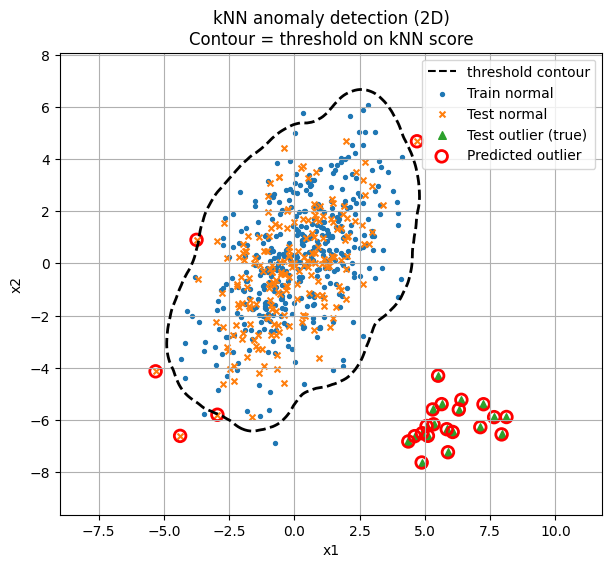

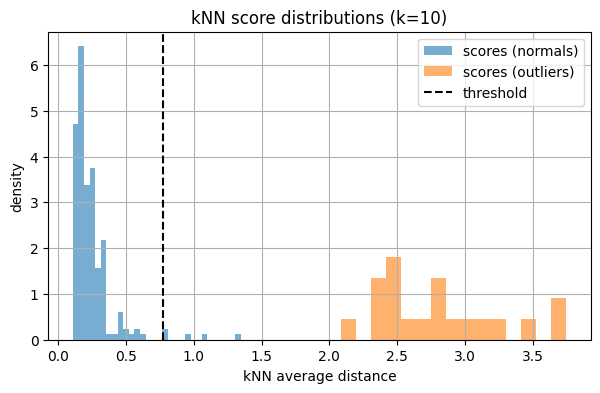

In [15]:
# ===== 6) 可視化 =====
# (a) 元空間の散布図＋しきい値等高線（格子上でスコアを計算）
x_min, y_min = (np.min(np.vstack([train, test]), axis=0) - 2)
x_max, y_max = (np.max(np.vstack([train, test]), axis=0) + 2)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_z = (grid - mu_hat) / std_hat

dist_grid = pairwise_l2(grid_z, train_z)
idx_k_grid = np.argpartition(dist_grid, kth=k, axis=1)[:, :k]
row_idx_g = np.arange(grid_z.shape[0])[:, None]
score_grid = dist_grid[row_idx_g, idx_k_grid].mean(axis=1).reshape(xx.shape)

plt.figure(figsize=(7,6))
# 等高線（しきい値）。凡例はダミー線で追加（環境依存の属性に触らない）
plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
plt.plot([], [], 'k--', label="threshold contour")

plt.scatter(train[:,0], train[:,1], s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_out[:,0],  test_out[:,1],  s=30, marker='^', label="Test outlier (true)")

# 異常に判定されたテスト点を赤丸で強調
flag_idx = np.where(pred==1)[0]
plt.scatter(test[flag_idx,0], test[flag_idx,1], s=70, facecolors='none',
            edgecolors='red', linewidths=2, label="Predicted outlier")

plt.title("kNN anomaly detection (2D)\nContour = threshold on kNN score")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(); plt.grid(True); plt.axis('equal')
plt.show()

# (b) スコアのヒストグラム（正常 vs 異常）＋しきい値線
plt.figure(figsize=(7,4))
plt.hist(score_test[labels==0], bins=30, density=True, alpha=0.6, label="scores (normals)")
plt.hist(score_test[labels==1], bins=15, density=True, alpha=0.6, label="scores (outliers)")
plt.axvline(thr, linestyle='--', color='k', label="threshold")
plt.title(f"kNN score distributions (k={k})")
plt.xlabel("kNN average distance"); plt.ylabel("density")
plt.legend(); plt.grid(True)
plt.show()
